# Final Project - Enhanced Reversal

### __Inputs__

In [1]:
# Local File Data Parameters #
fileName            = 'etfdata_new'          # File name to load in. Use no extension.
readInSasAndConvert = False                  # True: Reads in sas and converts to HDF. False: Reads in HDF.
createSubset        = True                   # Creates an hdf subset of the orig data using the dates below.
subsetStartDate     = '2018'                 # Start date of subset.
subsetEndDate       = '2020'                 # End date of subset.
useSubset           = True                   # True: backtest uses subset. False: Uses full original file. 
                                             # Note: True will throw an error if no subset has been created.    
# Alpaca API Data Parameters #
useAlpacaData       = True                   # True: load alpaca data. False: load local file data.
alpaca_start_date   = '2020-03-01'           # Start date of desired alpaca data.
alpaca_end_date     = '2020-03-08'           # End date of desired alpaca data.
stock_group         = 'sp500'                # sp100 or sp500.
afterHoursOn        = True                   # True: Leave after hours times. False: remove after hours times.
holdOvernight       = True                   # True: Hold positions overnight. False: close the position at the end of each day.
positionFilterOn    = True                   # True: Don't trade the period if there are fewer than positionMin securities to buy/short.
positionMin         = 3                      # The amount of required long and short securities to be in for the period.
    
# Test Parameters #
tile                = 'quintile'             # Tells the program which type of bin we'll use for the backtest
dataFreq            = 'hourly'               # Tell the program the frequency of the data being submitted
volumeFilterOn      = True                   # True: filter out entries based on the volume cutoff below. False: don't.
volumeCutoff        = 2000                   # Minimum previous-period trade volume to be included.
MovAvgPeriod        = 50                     # How many periods to calculate moving averages with.

#### __Imports__

In [2]:
import matplotlib as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import alpaca_trade_api as tradeapi
from scipy.optimize import minimize
from IPython.display import Markdown, display
try:
    import exceptions
except ImportError:
    import builtins as exceptions

ModuleNotFoundError: No module named 'alpaca_trade_api'

#### __Definitions__

In [ ]:
# General quantiles function that uses qcut and rank to assign bins
def quantiles(inser, nbins):
    outser = pd.qcut(inser.rank(method='first'), q=nbins, labels=range(1,nbins+1)) #inser.rank(method='first')
    return outser

# Dictionary for -tiles
tiles = {'percentile':100,
         'decile':10,
        'quintile':5,
        'quartile':4}

hiBin = tiles[tile]

# Dictionary for periods per year
pperYear = {'hourly':3000,
            'daily':250,
            'weekly':52,
            'monthly':12
           }

alpaca_timespans = {
    'minutely' : 'minute',
    'hourly' : 'hour',
    'daily' : 'day',
    'weekly' : 'week',
    'monthly' : 'month',
    'quarterly' : 'quarter',
    'yearly' : 'year'
}

def get_sp500_tickers():
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header=0)
    return table[0]['Symbol'].tolist()

def get_sp100_tickers():
    table = pd.read_html('https://en.wikipedia.org/wiki/S%26P_100', header=0)
    return table[2]['Symbol'].tolist()


stock_groups = {'sp100' : get_sp100_tickers(),    
                'sp500' : get_sp500_tickers()}

tickers      = stock_groups[stock_group]

# Easy t-stat function
def get_tstat(inser):
    return inser.mean() / inser.std() * np.sqrt(inser.count())

# Easy annualized Sharpe Ratio function
def get_sharpe_A(inser):
    return inser.mean() / inser.std() * np.sqrt(pperYear[dataFreq])

# Gets the Maximum Drawdown for the given series of returns
def get_max_dd(inser):
    val = np.cumprod(1 + inser).shift(1)
    val.iloc[0] = 1
    prior_high = val.cummax().shift(1)
    down_val = val / prior_high - 1
    down = down_val.apply(lambda x: np.minimum(0, x))
    down = -1 * down
    max_down = np.max(down)
    return max_down

# Gets the geometric annualized mean returns.
def get_geometric_mean(inser, years):
    return (get_emx(inser)**(1/years) - 1)

def get_emx(inser):
    return np.cumprod(1 + inser)[-1]

def daterange(start_date, end_date):
    startAsDate = datetime.strptime(start_date, '%Y-%m-%d')
    endAsDate = datetime.strptime(end_date, '%Y-%m-%d')
    for n in range(int((endAsDate - startAsDate).days)):
        yield startAsDate + timedelta(n)

def portfolio_stats(weights):
    port_ret = np.dot(weights, r) * pperYear[dataFreq]
    port_vol = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights))) * np.sqrt(pperYear[dataFreq])
    port_sharpe = port_ret/port_vol
    return {'return': port_ret, 'volatility': port_vol, 'sharpe': port_sharpe}

def min_vol(weights):
    return portfolio_stats(weights)['volatility']

def max_ret(weights):
    return -portfolio_stats(weights)['return']

def max_sharpe(weights):
    return -portfolio_stats(weights)['sharpe']        
        
def printmd(string):
    display(Markdown(string))
    
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

def highlight_max(s, color = 'yellow'):
    is_max = s == s.max()
    return ['background-color: '+ color if v else '' for v in is_max]

def highlight_min(s, color = 'yellow'):
    is_min = s == s.min()
    return ['background-color: '+ color if v else '' for v in is_min]

BASE_URL = 'https://paper-api.alpaca.markets'
API_KEY = 'PK4M2SVSERMB21HG885X'
SECRET_KEY = '253h8iLGSTe07Dk17gXIGRG522r4U126ngVSdOtj'

#### __Data Handling: Local File__

In [ ]:
if useAlpacaData != True:
    sasName = fileName + '.sas7bdat'
    hdfName = fileName + ".h5"
    hdfSubsetName = fileName + "_subset.h5"

    if readInSasAndConvert: # read in sas file and save as hdf file
        etf = pd.read_sas(sasName)
        etf = etf.drop(columns=['COMNAM','TICKER','SHROUT','DIVAMT','SHRCLS','NUMTRD','TSYMBOL','SHRCD'])
        etf.to_hdf(hdfName,'dataobj')

    else: # Read in hdf file
        etf = pd.read_hdf(hdfName,'dataobj',
                         parse_dates=True)

    if createSubset: # save a subset as an hdf file
        etfSub = etf.set_index(['DATE'])
        etfSub.sort_index(inplace=True)
        etfSub = etfSub.loc[subsetStartDate:] #subsetEndDate
        etfSub.reset_index(inplace=True)
        etfSub.to_hdf(hdfSubsetName,'dataobj')

    if useSubset: 
        try: # check if we can use the subset we just created which would be in memory already
            etf = etfSub
        except FileNotFoundError: print("No subset file. Turn createSubset to True to make one.")
        except: # if not, use the file. If this throws error, we know we don't have a subset file and need to make one
            etf = pd.read_hdf(hdfNameSub,'dataobj',
                         parse_dates=True)

    # Set index and sort
    etf.rename(columns = {'PERMNO':'ID','DATE':'DATETIME'},inplace = True)
    etf.set_index(['ID','DATETIME'], inplace = True)
    etf.sort_index(inplace = True)

    # Remove Duplicates
    etf = etf[~etf.index.duplicated(keep='first')]
    etf = etf.drop_duplicates(subset=
            ['PRC','VOL','OPENPRC','ASKHI','BIDLO','BID','ASK','RET','RETX'])
    
    df = etf

#### __Data Handling: Alpaca__

In [ ]:
if useAlpacaData == True:
    api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL)
    stocks = pd.DataFrame(columns = ['open','high','low','close','volume','vwap','ticker','timestamp'])
    stocks.set_index(['ticker','timestamp'], inplace = True)

    
    for date in pd.bdate_range(alpaca_start_date, alpaca_end_date):
        print(date)
        for ticker in tickers:
            data = api.polygon.historic_agg_v2(ticker, 1, alpaca_timespans[dataFreq],
                                               _from = date,
                                               to = date).df.reset_index()
            data['ticker'] = ticker
            data.set_index(['ticker','timestamp'], inplace = True)
            stocks = pd.concat([stocks, data], sort = True, verify_integrity = True)
    
    stocks.reset_index(inplace = True)
    stocks.rename(columns = {'volume':'VOL','timestamp':'DATETIME','ticker':'ID'}, inplace = True)
    stocks.set_index(['ID','DATETIME'], inplace = True)
    stocks.sort_index(inplace = True)
    
    stocks['RET'] = stocks['close'] / stocks['close'].groupby('ID').shift() - 1 if holdOvernight else stocks['close'] / stocks['open'] - 1
    stocks.dropna(inplace = True)
    
    df = stocks

In [4]:
%%script false --no-raise-error
# Read in CSV

stocks = pd.read_csv('sp500Feb_hourly.csv', parse_dates = ['DATETIME']) #, columns = ['open','high','low','close','volume','vwap','ticker','timestamp'])
stocks.reset_index(inplace = True)
stocks.drop(columns = 'index', inplace = True)
stocks.rename(columns = {'volume':'VOL','timestamp':'DATETIME','ticker':'ID'}, inplace = True)
stocks.set_index(['ID','DATETIME'], inplace = True)
stocks.sort_index(inplace = True)

stocks['RET'] = stocks['close'] / stocks['close'].groupby('ID').shift() - 1 if holdOvernight else stocks['close'] / stocks['open'] - 1
stocks.dropna(inplace = True)
df = stocks

In [5]:
df

NameError: name 'df' is not defined

In [8]:
%%script false --no-raise-error

# Potential to pull earnings and financials data for each stock and incorporate into strategy.
api.polygon.earnings(tickers)
api.polygon.financials(tickers)

#### Add Lagged Data

In [9]:
df['LAGRET'] = df['RET'].groupby('ID').shift()
df['LAGRET2'] = df['RET'].groupby('ID').shift(2)
df['LAGRET3'] = df['RET'].groupby('ID').shift(3)
df['LAGVOL'] = df['VOL'].groupby('ID').shift()
df['LAGVOL2'] = df['VOL'].groupby('ID').shift(2)
df['LAGVOL3'] = df['VOL'].groupby('ID').shift(3)

df['VOLDELTA'] = df['VOL'].groupby('ID').shift(1) / df['VOL'].groupby('ID').shift(2) - 1
df['VOLDELTAABS'] = np.abs(df['VOLDELTA'])


df.dropna(inplace = True)
df = df.reorder_levels(['DATETIME','ID'])
df.sort_index(inplace = True)

### Run Lagged Regressions

In [10]:
new_dict = {}
full_coefs = []
use_cols = ['LAGRET', 'LAGVOL', 'LAGRET2', 'LAGVOL2', 'LAGRET3', 'LAGVOL3', 'VOLDELTA']
indexes = []
for name, group in df.groupby("ID"):
    X = group[use_cols]
    y = group['RET']
    
    coefs = []
    
    for i in range(MovAvgPeriod, len(y)):
        X_train = X.iloc[i-MovAvgPeriod:i]
        y_train = y.iloc[i-MovAvgPeriod:i]
        
        reg = LinearRegression().fit(X_train, y_train)
        coefs.append(reg.coef_)
        new_dict[(name, group.index.get_level_values(0)[i])] = reg.predict(X.iloc[i].values.reshape(1,-1))[0]
    full_coefs.append(pd.DataFrame(coefs).mean())
    indexes.append(name)

### Create Lagged MA

In [11]:
df['LAGRETMA'] = df.groupby('ID').rolling(MovAvgPeriod).LAGRET2.mean().reset_index(0, drop = True)
df['VOLATIL'] = df.groupby('ID').rolling(MovAvgPeriod).LAGRET2.std().reset_index(0, drop = True)

df.dropna(inplace = True)
df = df.reorder_levels(['DATETIME','ID'])
df.sort_index(inplace = True)

In [12]:
raj_df = pd.Series(new_dict).reset_index()
raj_df.columns = ['ID', 'DATETIME', 'pred_ret']
raj_df.set_index(['DATETIME', 'ID'], inplace = True)
df = raj_df.merge(df, left_index = True, right_index = True, how = 'left')

### Create Ranking Bins

In [13]:
df['BIN'] = df['LAGRET'].groupby('DATETIME').apply(lambda x: quantiles(inser = x, nbins = hiBin))
df['VOLUMEBIN'] = df['LAGVOL'].groupby('DATETIME').apply(lambda x: quantiles(inser = x, nbins = hiBin))
df['VOLDELTABIN'] = df['VOLDELTA'].groupby('DATETIME').apply(lambda x: quantiles(inser = x, nbins = hiBin))
df['VOLDELTAABSBIN'] = df['VOLDELTAABS'].groupby('DATETIME').apply(lambda x: quantiles(inser = x, nbins = hiBin))
df['PREDBIN'] = df['pred_ret'].groupby('DATETIME').apply(lambda x: quantiles(inser = x, nbins = hiBin))

df.dropna(inplace = True)

### Generate Portfolio Weights

In [14]:
#df['LAGRETMANORM'] = (df.query('BIN == 1')['LAGRETMA'] - df.query('BIN == 1')['LAGRETMA'].groupby('DATETIME').min()) / (
#    df.query('BIN == 1')['LAGRETMA'].groupby('DATETIME').max() - df.query('BIN == 1')['LAGRETMA'].groupby('DATETIME').min())

df['LAGRETMAEXP'] = np.exp(df['LAGRETMA'])

df.reset_index(inplace = True)
df.set_index(['DATETIME','BIN'], inplace = True)
df.sort_index(inplace = True)

df['LAGRETMANORM'] = preprocessing.normalize([df['LAGRETMA'] + np.abs(df['LAGRETMA'].groupby(['DATETIME','BIN']).min())])[0]
df['WNORM'] = df['LAGRETMANORM'] / df['LAGRETMANORM'].groupby(['DATETIME','BIN']).sum()
df['WNEGNORM'] = -df['LAGRETMANORM'] / df['LAGRETMANORM'].groupby(['DATETIME','BIN']).sum()

df['WEXP'] = df['LAGRETMAEXP'] / df['LAGRETMAEXP'].groupby(['DATETIME','BIN']).sum()
df['WNEGEXP'] = -df['LAGRETMAEXP'] / df['LAGRETMAEXP'].groupby(['DATETIME','BIN']).sum()

df.reset_index(inplace = True)
df.set_index(['DATETIME','ID'], inplace = True)
df.sort_index(inplace = True)

#### __Filter Data__

In [15]:
if volumeFilterOn:
    rawCount = df.count(axis=0)[0]
    removedRows = df.query('LAGVOL < @volumeCutoff')
    df = df.query('LAGVOL >= @volumeCutoff')
    df.dropna(inplace = True)
    print("Entries removed for low volume: %i \nEnter 'removedRows' into a blank cell to view." % (rawCount - df.count(axis=0)[0]))
else:
    print("Filter turned off. No entries removed.")

if not afterHoursOn:
    df.reset_index(inplace = True)
    df.set_index('DATETIME', inplace = True)
    df = df.between_time(start_time='9:00', end_time='16:00', include_end = False)
    df.reset_index(inplace = True)
    df.set_index(['DATETIME', 'ID'], inplace = True)

Entries removed for low volume: 293 
Enter 'removedRows' into a blank cell to view.


#### Sort

In [16]:
df.reset_index(inplace = True)
df.set_index(['DATETIME','ID'], inplace = True)
df.sort_index(inplace = True)
duration = (df.index[-1][0] - df.index[0][0]).days
tradingPeriods = len(df.index.levels[0])

## Define Strategies

In [17]:
# Syntax for entering strategies is << ('StrategyName', 'what to go long on', 'what to go short on') >>

strategies = [
    ('LMH', 'BIN == 1', 'BIN == @hiBin'),
    ('LMH_VD_POS', 'BIN == 1 and VOLDELTABIN == @hiBin', 'BIN == @hiBin and VOLDELTABIN == @hiBin'),
    ('LMH_VD_NEG', 'BIN == 1 and VOLDELTABIN == 1', 'BIN == @hiBin and VOLDELTABIN == 1'),
    ('LMH_VD_ABS', 'BIN == 1 and VOLDELTAABSBIN == @hiBin', 'BIN == @hiBin and VOLDELTAABSBIN == @hiBin'),
    ('PRED', 'PREDBIN == @hiBin', 'PREDBIN == 1'),
]

stratBook = {
    'BuyHold' : df.groupby('DATETIME').RET.mean()
}

positionBook = {
    'BuyHold' : pd.DataFrame({'long': df.groupby('DATETIME').RET.count(),
                              'short': 0})
}

s = pd.DataFrame.from_records(strategies, columns = ['strat','long','short'], index = 'strat')

for i in range(len(s.index)):
        stratBook[s.index[i]] = (pd.DataFrame(df.query(s['long'].iloc[i])['RET']).groupby('DATETIME').mean().subtract(
        pd.DataFrame(df.query(s['short'].iloc[i])['RET']).groupby('DATETIME').mean(),
        fill_value = 0.0))['RET']
        
        positionBook[s.index[i]] = pd.DataFrame({'long': df.query(s['long'].iloc[i])['RET'].groupby('DATETIME').count(),
                                                 'short':df.query(s['short'].iloc[i])['RET'].groupby('DATETIME').count()})

        
stratBook['LMH_MOM_NORM'] = (pd.DataFrame(df.query(s['long'].loc['LMH'])['RET'] * df.query(s['long'].loc['LMH'])['WNORM']).groupby('DATETIME').sum().add(
                       pd.DataFrame(df.query(s['short'].loc['LMH'])['RET'] * df.query(s['short'].loc['LMH'])['WNEGNORM']).groupby('DATETIME').sum(),
        fill_value = 0.0))[0]

positionBook['LMH_MOM_NORM'] = pd.DataFrame({'long': df.query(s['long'].loc['LMH'])['RET'].groupby('DATETIME').count(),
                                                 'short':df.query(s['short'].loc['LMH'])['RET'].groupby('DATETIME').count()})

stratBook['LMH_MOM_EXP'] = (pd.DataFrame(df.query(s['long'].loc['LMH'])['RET'] * df.query(s['long'].loc['LMH'])['WEXP']).groupby('DATETIME').sum().add(
                       pd.DataFrame(df.query(s['short'].loc['LMH'])['RET'] * df.query(s['short'].loc['LMH'])['WNEGEXP']).groupby('DATETIME').sum(),
        fill_value = 0.0))[0]

positionBook['LMH_MOM_EXP'] = pd.DataFrame({'long': df.query(s['long'].loc['LMH'])['RET'].groupby('DATETIME').count(),
                                                 'short':df.query(s['short'].loc['LMH'])['RET'].groupby('DATETIME').count()})

if positionFilterOn:
    for strat in stratBook:
        if strat is not 'BuyHold':
            stratBook[strat].loc[positionBook[strat].query('long < @positionMin or short < @positionMin').index] = 0

#### Run Return Metrics on Each Strategy

In [18]:
strats = []
t_stats = []
sharpes = []
rets = []
sds = []
max_dd = []
geo = []
emx = []
wealth = pd.DataFrame()

for strat in stratBook:
    strats.append(strat)
    t_stats.append(get_tstat(stratBook[strat]))
    sharpes.append(get_sharpe_A(stratBook[strat]))
    rets.append(stratBook[strat].mean() * pperYear[dataFreq])
    sds.append(np.std(stratBook[strat] * np.sqrt(pperYear[dataFreq])))
    max_dd.append(get_max_dd(stratBook[strat]))
    geo.append(get_geometric_mean(stratBook[strat], tradingPeriods/pperYear[dataFreq]))
    emx.append(get_emx(stratBook[strat]))
    wealth[strat] = (1 + stratBook[strat]).cumprod()
    

results = pd.DataFrame([t_stats, sds, sharpes, rets, geo, max_dd, emx]).transpose()
results.columns = ['t_stat', 'SD', 'Sharpe', 'Arith Ret', 
                   'Geo Ret', 'Max DD', 'EMx']
results.index = strats
results.index.name = 'Strategy'

### Results

In [19]:
styles = [dict(selector="caption", props=[("caption-side", "bottom")])]

printmd("Backtest Time Period: **%s** thru **%s**" % (alpaca_start_date, alpaca_end_date))
printmd("Duration: %.2f years (**%s** trading %ss), " % (duration/365, tradingPeriods, alpaca_timespans[dataFreq]))

display(results.style.set_table_styles(styles).applymap(color_negative_red)\
.apply(lambda x: highlight_max(x, color='lime'), subset = ['t_stat','Sharpe','Arith Ret','Geo Ret','EMx'])\
.apply(lambda x: highlight_min(x, color='lime'), subset = ['SD','Max DD'])\
.set_caption("All return metrics except EMx are annualized.")\
.set_precision(2)\
.format({'t_stat':'{:0.2f}',
         'SD':'{:0.2f}',
         'Sharpe':'{:0.2f}',
         'EMx': '{:.2f}',
         'Arith Ret': '{:.2%}',
         'Geo Ret': '{:.2%}',
         'Max DD': '{:.2%}'})
       )

Backtest Time Period: **2020-03-01** thru **2020-03-08**

Duration: 0.00 years (**26** trading hours), 

,t_stat,SD,Sharpe,Arith Ret,Geo Ret,Max DD,EMx
Strategy,,,,,,,
BuyHold,-1.09,0.45,-11.71,-538.10%,-99.59%,6.03%,0.95
LMH,1.38,0.35,14.84,523.73%,17544.69%,1.72%,1.05
LMH_VD_POS,0.38,0.24,4.06,99.51%,162.76%,2.79%,1.01
LMH_VD_NEG,-0.41,0.17,-4.89,-83.38%,-49.58%,1.57%,0.99
LMH_VD_ABS,-0.28,0.17,-3.04,-53.07%,-42.04%,1.92%,1.00
PRED,-0.77,0.29,-8.31,-245.17%,-91.75%,3.35%,0.98
LMH_MOM_NORM,1.03,0.22,11.08,250.92%,1098.26%,1.23%,1.02
LMH_MOM_EXP,0.94,0.32,10.15,333.35%,2557.32%,1.72%,1.03


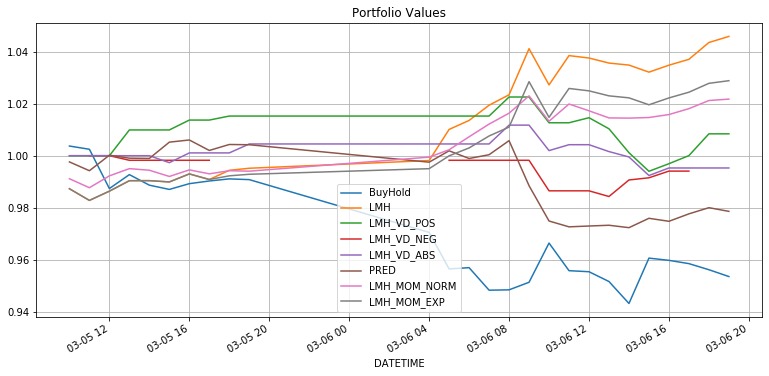

In [20]:
plot = wealth.plot(kind = 'line', figsize = (13,6), title = 'Portfolio Values', grid = True, subplots = False)

### Save Results
Manually execute the following cell to save the results of this backtest in the master results database.

In [21]:
#%%script false --no-raise-error

masterResults = 'masterResults.csv'

theseResults = results.copy()
theseResults['start'] = alpaca_start_date
theseResults['end'] = alpaca_end_date
theseResults['tradingPeriods'] = tradingPeriods
theseResults['tileSize'] = tile
theseResults['dataFreq'] = dataFreq
theseResults['volumeCutoff'] = volumeCutoff if volumeFilterOn == True else None
theseResults['dataSource'] = stock_group if useAlpacaData else 'etfs'
#theseResults['testDateTime'] = datetime.now()
theseResults.reset_index(inplace = True)
theseResults.set_index(['start','end','tileSize','dataFreq','tradingPeriods','volumeCutoff','dataSource', 'Strategy'],
                       inplace = True)
theseResults.sort_index(inplace = True)

databaseIsMissing = False
try:
    mrDF = pd.read_csv(masterResults, parse_dates=True)
except FileNotFoundError:
    mrDF = theseResults
    databaseIsMissing = True
else:
    mrDF.set_index(['start','end','tileSize','dataFreq','tradingPeriods','volumeCutoff','dataSource','Strategy'],
                       inplace = True)

mrDF.sort_index(inplace = True)
if not databaseIsMissing:
    try:
        mrDF = pd.concat([mrDF, theseResults], sort = True, verify_integrity = True)
    except:
        print("Identical backtest already in database, will not add.")

mrDF.to_csv(masterResults)    

#### Verify HML With Hourly Data

In [22]:
if dataFreq == 'hourly':
    from datetime import timedelta, date
    import pytz
    tz = pytz.timezone('America/New_York')

    def daterange(start_date, end_date):
        for n in range(int((end_date - start_date).seconds//3600)+1):
            yield start_date + timedelta(hours=n)

    totalWealth = 1
    dailyWealth = 1
    dayCount = 1
    currentDay = df.index.levels[0][0].day
    currentMonth = df.index.levels[0][0].month
    for time in df.index.levels[0]:
        if time.day != currentDay:
            printmd("Total return for Day %d, %s/%s: **%.2f%%**" % (dayCount, currentMonth, currentDay, (dailyWealth-1)*100))
            dailyWealth = 1
            dayCount = dayCount + 1
            currentDay = time.day
            if time.month != currentMonth:
                currentMonth = time.month
        long = df[df['BIN']==1].loc[time]['RET'].mean()
        short = df[df['BIN']==hiBin].loc[time]['RET'].mean()
        total = long - short
        totalWealth = totalWealth * (1 + total)
        dailyWealth = dailyWealth * (1 + total)
        print("%s >> Long Return: %.3f - Short Return: %.3f = Total Return: %.3f. Cumulative Wealth: %.3f" % (time, long, short, total, totalWealth))
    printmd("Total return for Day %d, %s/%s: **%.2f%%**" % (dayCount, currentMonth, currentDay, (dailyWealth-1)*100))
    printmd("Total return of HML for Sample: **%.2f%%**" % ((totalWealth-1)*100))

2020-03-05 10:00:00-05:00 >> Long Return: -0.004 - Short Return: 0.008 = Total Return: -0.013. Cumulative Wealth: 0.987
2020-03-05 11:00:00-05:00 >> Long Return: -0.002 - Short Return: 0.002 = Total Return: -0.005. Cumulative Wealth: 0.983
2020-03-05 12:00:00-05:00 >> Long Return: -0.014 - Short Return: -0.018 = Total Return: 0.004. Cumulative Wealth: 0.986
2020-03-05 13:00:00-05:00 >> Long Return: 0.008 - Short Return: 0.004 = Total Return: 0.004. Cumulative Wealth: 0.990
2020-03-05 14:00:00-05:00 >> Long Return: -0.005 - Short Return: -0.005 = Total Return: 0.000. Cumulative Wealth: 0.990
2020-03-05 15:00:00-05:00 >> Long Return: -0.004 - Short Return: -0.004 = Total Return: -0.001. Cumulative Wealth: 0.990
2020-03-05 16:00:00-05:00 >> Long Return: 0.004 - Short Return: 0.001 = Total Return: 0.003. Cumulative Wealth: 0.993
2020-03-05 17:00:00-05:00 >> Long Return: 0.001 - Short Return: 0.003 = Total Return: -0.002. Cumulative Wealth: 0.991
2020-03-05 18:00:00-05:00 >> Long Return: 0.

Total return for Day 1, 3/5: **-0.48%**

2020-03-06 04:00:00-05:00 >> Long Return: -0.016 - Short Return: -0.019 = Total Return: 0.003. Cumulative Wealth: 0.998
2020-03-06 05:00:00-05:00 >> Long Return: -0.010 - Short Return: -0.022 = Total Return: 0.012. Cumulative Wealth: 1.010
2020-03-06 06:00:00-05:00 >> Long Return: -0.004 - Short Return: -0.007 = Total Return: 0.003. Cumulative Wealth: 1.014
2020-03-06 07:00:00-05:00 >> Long Return: -0.003 - Short Return: -0.009 = Total Return: 0.006. Cumulative Wealth: 1.019
2020-03-06 08:00:00-05:00 >> Long Return: 0.002 - Short Return: -0.002 = Total Return: 0.004. Cumulative Wealth: 1.023
2020-03-06 09:00:00-05:00 >> Long Return: 0.011 - Short Return: -0.006 = Total Return: 0.017. Cumulative Wealth: 1.041
2020-03-06 10:00:00-05:00 >> Long Return: 0.011 - Short Return: 0.025 = Total Return: -0.013. Cumulative Wealth: 1.027
2020-03-06 11:00:00-05:00 >> Long Return: -0.010 - Short Return: -0.021 = Total Return: 0.011. Cumulative Wealth: 1.038
2020-03-06 12:00:00-05:00 >> Long Return: -

Total return for Day 2, 3/6: **5.09%**

Total return of HML for Sample: **4.59%**

In [23]:
df

BIN  pred_ret      close       high        low  \
DATETIME                  ID                                                    
2020-03-05 10:00:00-05:00 AAL    1  0.013106    16.7400    17.1800    16.7000   
                          AAPL   3  0.005391    74.4200    74.8100    73.5750   
                          AMD    4  0.010122    49.1250    49.4700    48.5738   
                          BAC    2  0.001450    27.0150    27.1400    26.7900   
                          CCL    1 -0.000441    29.0700    30.1750    29.0200   
                          CSCO   2  0.003943    40.0400    40.3700    39.8000   
                          DAL    1  0.003972    45.8050    46.4100    45.4600   
                          DIS    1 -0.027216   114.4100   115.1800   113.1000   
                          FB     4 -0.001651   187.2000   188.8300   186.8500   
                          GILD   5  0.008499    77.0300    77.5000    76.2500   
                          INTC   5  0.004184    58.3350    58.5400    57.6500   
                          JPM    2  0.000526   114.7700   115.1700   113.6200   
                          MSFT   4 -0.004207   169.0640   169.6699   166.4300   
                          MU     5  0.007844    54.5750    55.0000    53.8800   
                          NVDA   3  0.006306   279.1800   281.6974   274.8500   
                          PFE    3  0.006659    35.8300    35.8598    35.4600   
                          PYPL   5  0.010331   113.7400   114.5000   112.6400   
                          TWTR   4 -0.002004    35.4400    35.5500    35.1600   
                          V      3  0.008262   190.3000   191.2200   188.7700   
                          XOM    2  0.006973    49.9400    50.2200    49.7700   
2020-03-05 11:00:00-05:00 AAL    1  0.009284    16.8150    17.0700    16.7200   
                          AAPL   4  0.001554    74.3525    74.8875    74.2125   
                          AMAT   5 -0.000921    59.9200    60.4400    59.6200   
                          AMD    3  0.002783    49.1000    49.7200    48.8200   
                          AMZN   2  0.001819  1945.2393  1960.7200  1941.6839   
                          BA     1 -0.000037   269.2715   270.9399   268.3800   
                          BAC    3  0.002157    26.9950    27.3500    26.9500   
                          CCL    1  0.009503    28.5154    29.2700    28.4201   
                          CSCO   1  0.002530    40.1650    40.5100    39.9800   
                          DAL    4 -0.001337    45.7900    46.3900    45.7000   
...                             ..       ...        ...        ...        ...   
2020-03-06 19:00:00-05:00 DIS    1 -0.000350   114.7000   114.8000   114.6000   
                          F      4 -0.003829     6.4900     6.4900     6.4100   
                          FB     3 -0.001273   179.9800   179.9800   179.5000   
                          GE     1 -0.007744     9.3200     9.3600     9.3000   
                          GILD   5  0.001016    80.1800    80.1800    79.9400   
                          GLW    4 -0.002557    24.7500    24.7500    24.7500   
                          GM     4 -0.002748    28.6700    28.6700    28.5500   
                          HAL    4 -0.007710    13.1400    13.1400    13.1000   
                          INTC   2 -0.000731    55.3800    55.3800    55.3800   
                          JPM    2 -0.003092   107.3300   107.5000   107.3300   
                          LLY    3 -0.003215   141.4000   141.4000   141.4000   
                          MOS    5 -0.006084    14.1600    14.3000    14.1600   
                          MS     1 -0.004725    41.4500    41.5000    41.4500   
                          MSFT   4 -0.000469   160.2000   160.8900   160.0000   
                          MU     1 -0.002572    51.0500    51.2600    51.0100   
                          NCLH   2 -0.002792    27.0000    27.0000    26.7100   
                          NKE    2 -0.002878    87.1400    87.

#### Leftover Code

In [24]:
%%script false --no-raise-error

# Potential strategies
    'LMH_VOLSTD' : (pd.DataFrame(
        df.query('BIN == 1 and VOLSTDBIN != 1'
                     )['RET']).groupby('DATETIME').mean() - pd.DataFrame(
        df.query('BIN == 4 and VOLSTDBIN != 1')['RET']).groupby('DATETIME').mean())['RET'] ,
        
    'LMH_VD_HiVol' : (pd.DataFrame(
        df.query('BIN == 1 and VOLDELTAABSBIN == 4 and VOLUMEBIN != 1'
                     )['RET']).groupby('DATETIME').mean() - pd.DataFrame(
        df.query('BIN == 4 and VOLDELTAABSBIN == 4 and VOLUMEBIN != 1')['RET']).groupby('DATETIME').mean())['RET'] ,   
        
    'LMH_VD_ABS_LoVol' : (pd.DataFrame(
        df.query('BIN == 1 and VOLDELTAABSBIN == @hiBin and VOLUMEBIN == 1'
                     )['RET']).groupby('DATETIME').mean() - pd.DataFrame(
        df.query('BIN == @hiBin and VOLDELTAABSBIN == @hiBin and VOLUMEBIN == 1')['RET']).groupby('DATETIME').mean())['RET'] , 
    
    'LMH_VD_NEG_LoVol' : (pd.DataFrame(
        df.query('BIN == 1 and VOLDELTABIN == 1 and VOLUMEBIN == 1'
                     )['RET']).groupby('DATETIME').mean() - pd.DataFrame(
        df.query('BIN == @hiBin and VOLDELTABIN == 1 and VOLUMEBIN == 1')['RET']).groupby('DATETIME').mean())['RET'] ,     
    
    'LMH_VD_POS_LoVol' : (pd.DataFrame(
        df.query('BIN == 1 and VOLDELTABIN == @hiBin and VOLUMEBIN == 1'
                     )['RET']).groupby('DATETIME').mean() - pd.DataFrame(
        df.query('BIN == @hiBin and VOLDELTABIN == @hiBin and VOLUMEBIN == 1')['RET']).groupby('DATETIME').mean())['RET'] , 
    
    'LMH_LoVol' : (pd.DataFrame(
        df.query('BIN == 1 and VOLUMEBIN == 1'
                     )['RET']).groupby('DATETIME').mean() - pd.DataFrame(
        df.query('BIN == @hiBin and VOLUMEBIN == 1')['RET']).groupby('DATETIME').mean())['RET']

# The good ones.
    'LMH' : (pd.DataFrame(df.query('BIN == 1')['RET']).groupby('DATETIME').mean().subtract(
        pd.DataFrame(df.query('BIN == @hiBin')['RET']).groupby('DATETIME').mean(),
        fill_value = 0.0))['RET'] ,

    'LMH_VD_POS' : (pd.DataFrame(df.query('BIN == 1 and VOLDELTABIN == @hiBin')['RET']).groupby('DATETIME').mean().subtract(
        pd.DataFrame(df.query('BIN == @hiBin and VOLDELTABIN == @hiBin')['RET']).groupby('DATETIME').mean(),
        fill_value = 0.0))['RET'] ,

    'LMH_VD_NEG' : (pd.DataFrame(df.query('BIN == 1 and VOLDELTABIN == 1')['RET']).groupby('DATETIME').mean().subtract(
        pd.DataFrame(df.query('BIN == @hiBin and VOLDELTABIN == 1')['RET']).groupby('DATETIME').mean(),
        fill_value = 0.0))['RET'] ,
    
    'LMH_VD_ABS' : (pd.DataFrame(df.query('BIN == 1 and VOLDELTAABSBIN == @hiBin')['RET']).groupby('DATETIME').mean().subtract(pd.DataFrame(
        df.query('BIN == @hiBin and VOLDELTAABSBIN == @hiBin')['RET']).groupby('DATETIME').mean(),
        fill_value = 0.0))['RET'] 
